In [1]:
import sys
import os
import polars as pl
import numpy as np
# Add the project root directory to PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.insert(0, project_root)

# Import necessary modules
import groundinsight as gi
from groundinsight.models.core_models import BusType, BranchType




In [ ]:
gi.start_dbsession(sqlite_path="grounding.db")

Frequency: 0.0 Hz, Reduction Factor: 1.0
Frequency: 50.0 Hz, Reduction Factor: 0.41424344670265417
Frequency: 250.0 Hz, Reduction Factor: 0.18569533817705183
Frequency: 350.0 Hz, Reduction Factor: 0.17666431737550262
Frequency: 450.0 Hz, Reduction Factor: 0.1727921602262105
Frequency: 550.0 Hz, Reduction Factor: 0.1707943972035084
Frequency: 0.0 Hz, Grounding Impedance: 0.2408515076331461
Frequency: 50.0 Hz, Grounding Impedance: 0.45552531477123664
Frequency: 250.0 Hz, Grounding Impedance: 1.8286869510073225
Frequency: 350.0 Hz, Grounding Impedance: 2.544121995277182
Frequency: 450.0 Hz, Grounding Impedance: 3.2624523864036448
Frequency: 550.0 Hz, Grounding Impedance: 3.9821240847695445
shape: (294, 6)
┌────────────┬───────────┬──────────────┬───────────────────┬───────────────────┬──────────────────┐
│ fault_name ┆ fault_bus ┆ frequency_Hz ┆ grounding_impedan ┆ grounding_impedan ┆ reduction_factor │
│ ---        ┆ ---       ┆ ---          ┆ ce_Ohm            ┆ ce_deg            ┆ --- 

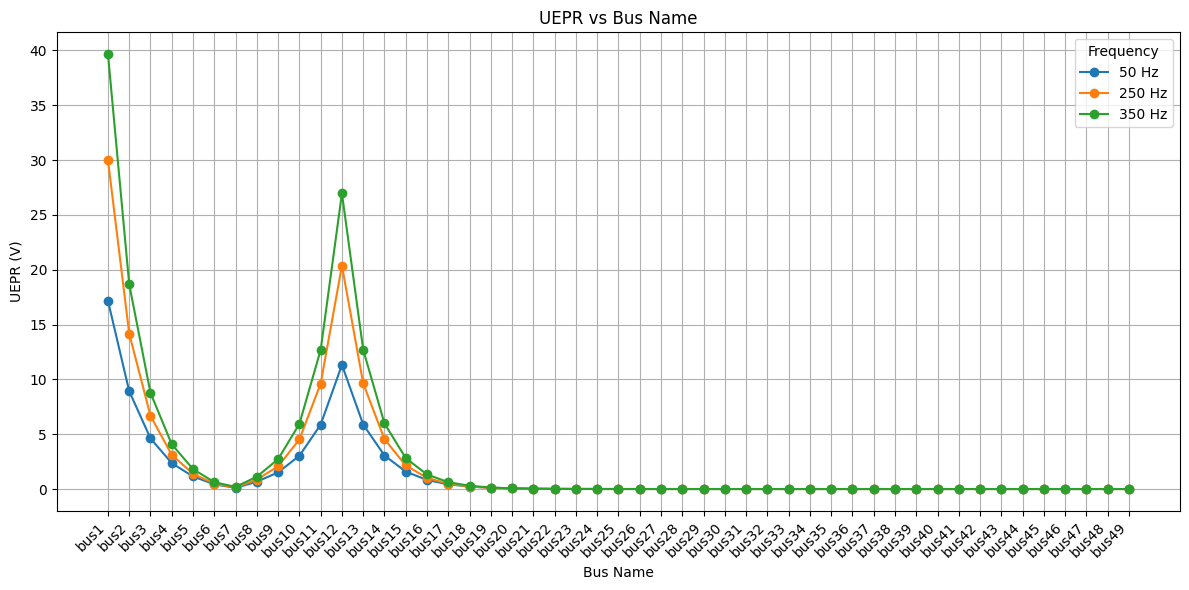

In [6]:

#Test the calculation formula of the impedance
# Create a network
net = gi.create_network(name="MyTestNetwork", frequencies=[0, 50, 250, 350, 450, 550])
net.description = "That's my first test network"

bus_type = BusType(
    name="BusTypeFormulaTest",
    description="Example bus type with parameters",
    system_type="Grounded",
    voltage_level=230.0,
    impedance_formula="rho * 0 + 1 + I * f * 1/50",
)

bus_type_uw = BusType(
    name="BusTypeFormulaTestUW",
    description="Example bus type with parameters",
    system_type="Grounded",
    voltage_level=230.0,
    impedance_formula="rho * 0 + 0.1 + I * f * 1/50",
)

branch_type = BranchType(
    name="TestBranchType",
    description="A test branch type",
    carry_current=True,
    self_impedance_formula="(rho * 0 + 0.25 + j * f * 0.012)*l",
    mutual_impedance_formula="(rho * 0 + 0.0 + j * f * 0.010)*l"
)

branch_ohl = BranchType(
    name="OHLine",
    description="An overhead line",
    carry_current=False,
    self_impedance_formula="NaN",
    mutual_impedance_formula="NaN"
)

number_buses = 50
#create buses with a for loop
for i in range(1, number_buses):
    gi.create_bus(name=f"bus{i}", type=bus_type, network=net, specific_earth_resistance=100.0)


#create branch 
#defining a line length of each branch
line_length = 1

#create bracnches with a for loop
for i in range(1, number_buses-1):
    gi.create_branch(name=f"branch{i}", type=branch_type, from_bus=f"bus{i}", to_bus=f"bus{i+1}", length=line_length, specific_earth_resistance=100.0, network=net)


#net.add_bus(bus2, overwrite=True)

#create a faults
fault_scaling = {0:1, 50: 1.0, 250: 1}
faultnames = []
for i in range(1, number_buses):
    gi.create_fault(name=f"fault{i}", bus=f"bus{i}", description="A fault at bus {i}", scalings=fault_scaling, network=net)
    faultnames.append(f"fault{i}")



#add a source at bus1
source = gi.create_source(name="source1", bus="bus1", values={0:10, 50:60, 250:60, 350:60, 450:60, 550:60}, network=net)
#source2 = gi.create_source(name="source2", bus="bus6", values={0:0, 50:30, 250:30, 350:30}, network=net)

#define the paths of the network
gi.create_paths(network=net)

#for loop over each fault
#TODO CHECK FOR PARALLEL PROCESSING WITH CUNCURRENT OR MULTIPROCESSING
for i in range(number_buses-1):
    # Run fault calculations
    gi.run_fault(net, fault_name=f"fault{i+1}")




# Access results
res_bus_df = net.res_buses(fault="fault8")

res_branch_df = net.res_branches(fault="fault8")

res_branch_branch1 = res_branch_df.filter(pl.col('branch_name') == 'branch2')
res_bus7 = res_bus_df.filter(pl.col('bus_name') == 'bus7')


# Access the reduction factors
result = net.results["fault12"]
reduction_factors = result.reduction_factor.value

# Access the grounding impedances
grounding_impedances = result.grounding_impedance.value

# Print reduction factors
for freq, rf in reduction_factors.items():
    print(f"Frequency: {freq} Hz, Reduction Factor: {rf}")

# Print the grounding impedances
for freq, z in grounding_impedances.items():
    try:
        print(f"Frequency: {freq} Hz, Grounding Impedance: {np.abs(z)}")
    except:
        print("Exception")

print(net.res_all_impedances())

gi.plot_bus_voltages(result=result, frequencies=[50, 250, 350], show=False);
#gi.plot_branch_currents(result=result)
#gi.plot_bus_currents(result=result)



In [ ]:
#try the json saving
path = "network.json"
gi.save_network_to_json(net, path)

reconvert_net = gi.load_network_from_json(path)
print(net.faults)
print(reconvert_net.faults)
#define the paths of the network
gi.create_paths(network=reconvert_net)

#for loop over each fault
for i in range(9):
    # Run fault calculations
    gi.run_fault(reconvert_net, fault_name=f"fault{i+1}")

result = reconvert_net.results["fault8"]

print(net.res_all_impedances())

#gi.plot_bus_voltages(result=result, frequencies=[50], show=False);

In [ ]:
#define the paths of the network
gi.create_paths(network=net)

#for loop over each fault
for i in range(9):
    # Run fault calculations
    gi.run_fault(reconvert_net, fault_name=f"fault{i+1}")

result = reconvert_net.results["fault8"]

print(net.res_all_impedances())

gi.plot_bus_voltages(result=result, frequencies=[50], show=False);

In [ ]:
#test the network to database function
gi.start_dbsession()
gi.save_network(network=net, overwrite=True)

In [ ]:
loaded_net = gi.load_network(name="MyTestNetwork")



In [ ]:
#create a dummy bus type
bus_type = BusType(
    name="DummyBusType",
    description="A dummy bus type",
    system_type="Grounded",
    voltage_level=20,
    impedance_formula="rho / 100 + f / 200 + I * sqrt(f / 20)",
    parameters={}  # No additional parameters needed in this case
)
#save the bustype
gi.save_bustype(bus_type, overwrite=True)

#check the database interface for bus types
bus_types = gi.load_bustypes()

#print all names of the bus types
for name, bt in bus_types.items():
    #iterate over all properties of a bustype
    for prop in bt.__dict__:
        print(f"{prop}: {bt.__dict__[prop]}")
        #print a space
    print("\n")
    



#save the branch with the name "branch_ohl"
gi.save_branchtype(branch_ohl, overwrite=True)

#check the database interface for branch types
branch_types = gi.load_branchtypes()

#print all names of the branch types
for name, bt in branch_types.items():
    #iterate over all properties of a bustype
    for prop in bt.__dict__:
        print(f"{prop}: {bt.__dict__[prop]}")
    print("\n")
    

In [ ]:
#test the execution time 

# Define common types
bus_type = gi.BusType(
    name="BusTypeFormulaTest",
    description="Example bus type with parameters",
    system_type="Grounded",
    voltage_level=230.0,
    impedance_formula="rho * 0 + 1 + I * f * 1/50",
)

branch_type = gi.BranchType(
    name="TestBranchType",
    description="A test branch type",
    carry_current=True,
    self_impedance_formula="(rho * 0 + 0.25 + I * f * 0.012)*l",
    mutual_impedance_formula="(rho * 0 + 0.0 + I * f * 0.010)*l"
)

# Create a network
net = gi.create_network(name="LargeTestNetwork", frequencies=range(0,1000,1))
net.description = "Test network with 100 buses and corresponding branches"

# Create buses
num_buses = 100
for i in range(1, num_buses + 1):
    gi.create_bus(
        name=f"bus{i}",
        type=bus_type,
        network=net,
        specific_earth_resistance=100 + i,  # Example resistance variation
    )

# Create branches
for i in range(1, num_buses):
    gi.create_branch(
        name=f"branch{i}",
        type=branch_type,
        from_bus=f"bus{i}",
        to_bus=f"bus{i+1}",
        length=1 + i * 0.01,  # Example length variation
        specific_earth_resistance=150 + i * 10,  # Example resistance variation
        network=net,
    )

# Add a fault at each bus
fault_scaling = {0: 1, 50: 1.0, 250: 1, 500: 1}
for i in range(1, num_buses + 1):
    gi.create_fault(
        name=f"fault{i}",
        bus=f"bus{i}",
        description=f"Fault at bus{i}",
        scalings=fault_scaling,
        network=net,
    )

# Add a source at the first bus
gi.create_source(
    name="source1",
    bus="bus1",
    values={50: 60, 250: 40, 500: 20},
    network=net,
)

# Define paths
net.define_paths()

# Time the network calculations
import time
start_time = time.time()

# Loop through all faults and run fault calculations
for i in range(1, num_buses + 1):
    net.set_active_fault(f"fault{i}")
    gi.run_fault(net)

# Measure elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time for fault calculations: {elapsed_time:.2f} seconds")

# Access and print results for a specific fault
fault_name = "fault50"  # Example fault to analyze
res_bus_df = net.res_buses(fault=fault_name)
res_branch_df = net.res_branches(fault=fault_name)

print(f"Results for {fault_name}:")
print("Bus Results:")
print(res_bus_df)
print("Branch Results:")
print(res_branch_df)

# Access reduction factors and grounding impedances
result = net.results[fault_name]
reduction_factors = result.reduction_factor.value
grounding_impedances = result.grounding_impedance.value

# Print reduction factors
print("\nReduction Factors:")
for freq, rf in reduction_factors.items():
    print(f"Frequency: {freq} Hz, Reduction Factor: {rf}")

# Print grounding impedances
print("\nGrounding Impedances:")
for freq, z in grounding_impedances.items():
    try:
        print(f"Frequency: {freq} Hz, Grounding Impedance: {np.abs(z)}")
    except:
        print(f"Frequency: {freq} Hz, Exception in computing grounding impedance")

# Summarize impedance results
print("\nAll Impedances:")
print(net.res_all_impedances())


In [ ]:
#save the network to the database
gi.start_dbsession()
gi.save_network(network=net, overwrite=True)

In [ ]:
loaded_net = gi.load_network(name="LargeTestNetwork")

gi.run_fault(loaded_net)
